In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix


# Dealing with the data

## Data collection

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient</apan>.

In [ ]:
df = pd.read_csv('dataset-stroke.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Data information

In [ ]:
del df['id'] #not important; it just adds noise

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

For the bmi column, there are 201 rows without a value, so we need to deal with that missing value.

In [ ]:
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


The missing values are 3.93%, so about 4% of the data in the BMI column, so we can drop them since it is a very low percentage.

In [ ]:
df.dropna(how='any', inplace=True) #this is to remove the rows with missing values since the % is low

Now we assign the numerical and categorical data.

In [ ]:
numerical_data = ['age', 'bmi', 'avg_glucose_level']
categorical_data = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

## Data visualization

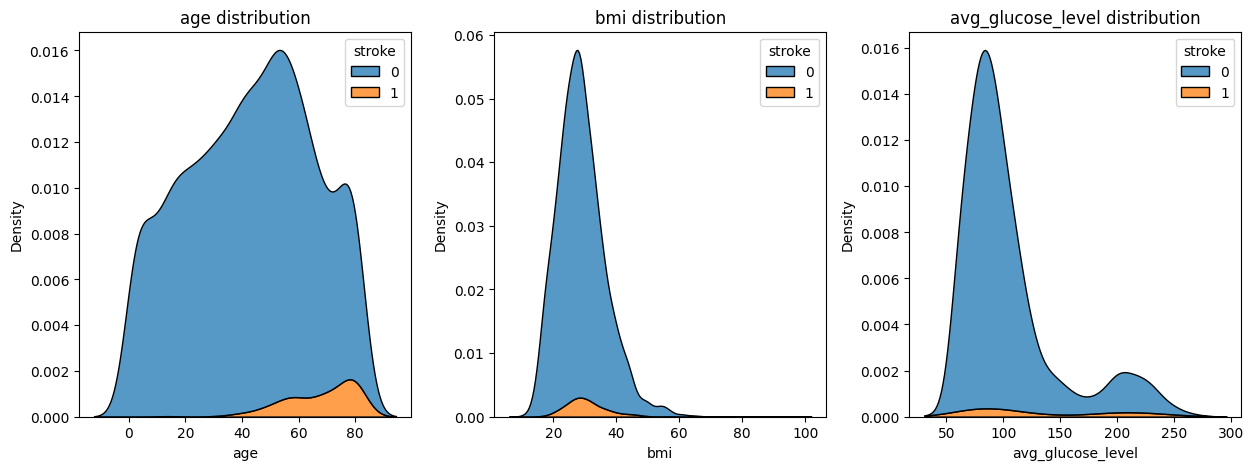

In [ ]:
i = 0
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.25) 

for i, num_col in enumerate(numerical_data):
    sns.kdeplot(x=num_col, hue='stroke', data=df, multiple='stack', ax=ax[i])
    ax[i].set_title(f'{num_col} distribution')

plt.show()

This data visualisation helps us better understand the data, the results that we can conclude are the following:

1- The age range of people who have had a stroke is from 40 to 85 with a peak at 80 years old.

2- The BMI range is from 20 to 40 with a peak at almost 30.

3- The glucose level range is from 40 to 250.

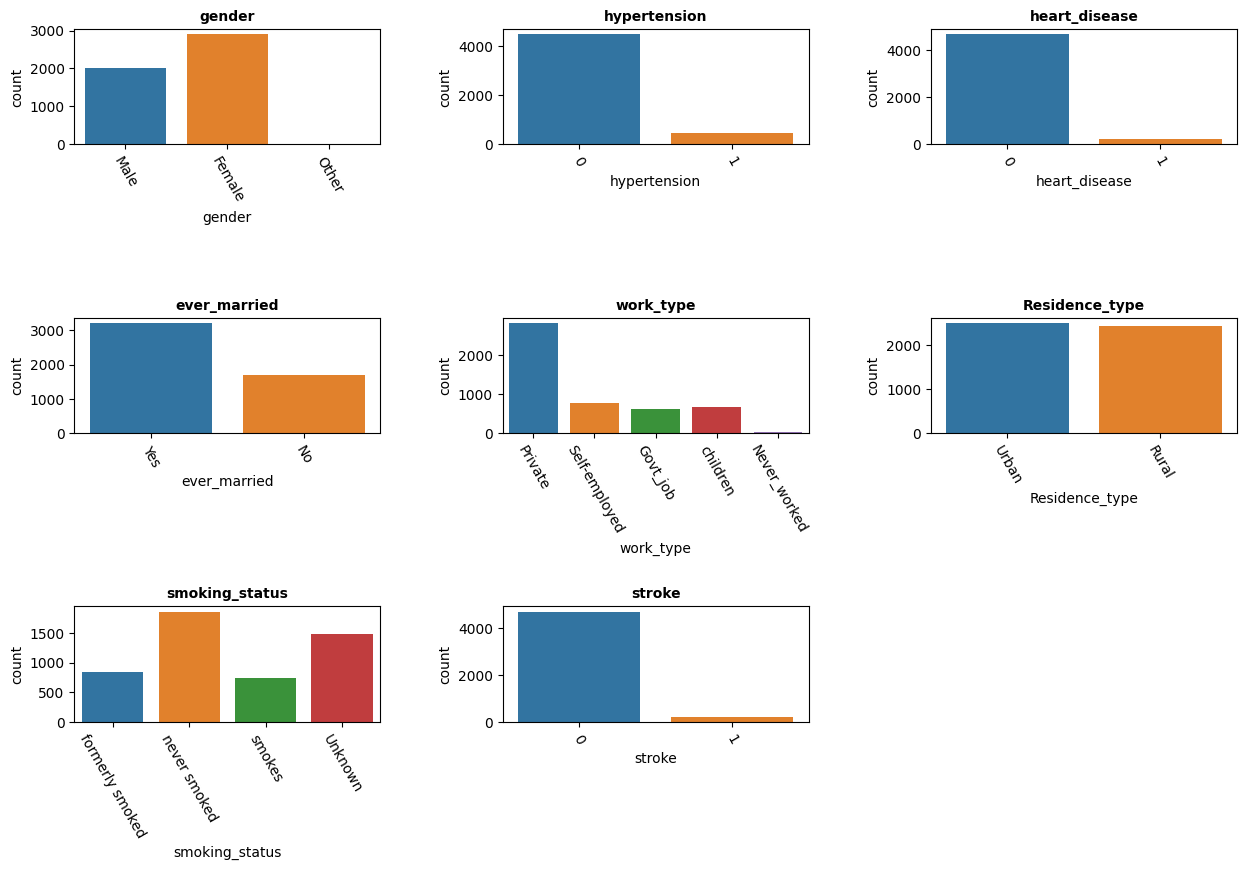

In [ ]:
num_features = len(categorical_data)
num_rows = (num_features - 1) // 3 + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
plt.subplots_adjust(hspace=1.5, wspace=0.4)  # Adjust space between subplots

i = 0
for row in range(num_rows):
    for col in range(3):
        if i < num_features:
            sns.countplot(x=categorical_data[i], data=df, ax=axes[row, col])
            axes[row, col].set_title(categorical_data[i], size=10, weight='bold', color='black')
            axes[row, col].tick_params(axis='x', rotation=300)
            i += 1
        
        else:
            # If there are fewer than 9 features, delete the unused subplots
            fig.delaxes(axes[row, col])

plt.show()




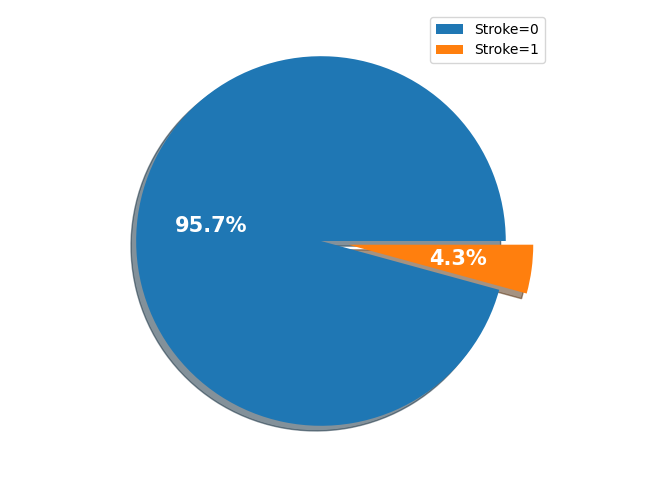

In [ ]:
x = df['stroke'].value_counts()


explode = [0, 0.15]
labels = ['Stroke=0', 'Stroke=1']
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

plt.pie(x, explode=explode, shadow=True, autopct='%1.1f%%', labels=labels, textprops=dict(color="w", weight='bold', size=15))
plt.legend()
plt.show()

Here we can see that only about 4% of our samples had a stroke.

# Data preprocessing

After well observing our dataset, we notice that we have both numerical and categorical data. 

In order to deal with the categorical data, we will first count the number of unique values in each categorical column.

In [ ]:
columns_temp = ['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']

for col in columns_temp :
    print('column :', col)
    for index, unique in enumerate(df[col].unique()) :
        print(unique, ':', index)
    print('_'*45)

column : gender
Male : 0
Female : 1
Other : 2
_____________________________________________
column : ever_married
Yes : 0
No : 1
_____________________________________________
column : work_type
Private : 0
Self-employed : 1
Govt_job : 2
children : 3
Never_worked : 4
_____________________________________________
column : smoking_status
formerly smoked : 0
never smoked : 1
smokes : 2
Unknown : 3
_____________________________________________
column : Residence_type
Urban : 0
Rural : 1
_____________________________________________


 now we apply one hot encoder to the categorical columns:

In [ ]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type']
df = pd.get_dummies(df, columns=categorical_columns)
print(df)


       age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0     67.0             0              1             228.69  36.6       1   
2     80.0             0              1             105.92  32.5       1   
3     49.0             0              0             171.23  34.4       1   
4     79.0             1              0             174.12  24.0       1   
5     81.0             0              0             186.21  29.0       1   
...    ...           ...            ...                ...   ...     ...   
5104  13.0             0              0             103.08  18.6       0   
5106  81.0             0              0             125.20  40.0       0   
5107  35.0             0              0              82.99  30.6       0   
5108  51.0             0              0             166.29  25.6       0   
5109  44.0             0              0              85.28  26.2       0   

      gender_Female  gender_Male  gender_Other  ever_married_No  ...  \
0              

In [ ]:
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
2,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
5,81.0,0,0,186.21,29.0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,103.08,18.6,0,1,0,0,1,...,0,0,0,1,1,0,0,0,1,0
5106,81.0,0,0,125.20,40.0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5107,35.0,0,0,82.99,30.6,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
5108,51.0,0,0,166.29,25.6,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0


As for the numerical columns, we need to normalize them: we will do so using the MinMaxScaler.

In [ ]:
X = df.drop(columns=['stroke'])
y = df['stroke']

In [ ]:
scaler = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(scaler, columns=X.columns)
X.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Urban
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,...,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,0.522282,0.091872,0.049501,0.231674,0.212981,0.590141,0.409656,0.000204,0.347321,0.652679,...,0.004482,0.572622,0.157873,0.136688,0.302098,0.170503,0.377266,0.150132,0.492768,0.507232
std,0.275331,0.288875,0.216934,0.205080,0.089966,0.491858,0.491820,0.014273,0.476167,0.476167,...,0.066801,0.494748,0.364659,0.343552,0.459214,0.376113,0.484752,0.357238,0.499999,0.499999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.304199,0.000000,0.000000,0.101330,0.151203,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.536133,0.000000,0.000000,0.168775,0.203895,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.731445,0.000000,0.000000,0.269827,0.261168,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now that we have pre-processed our data, we can start with the modelling:

# Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ML models

## Logistic regression

In [ ]:
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'penalty': ['l2'],
                     'fit_intercept': [True, False],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [ ]:
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='f1', error_score='raise')
grid_search_lr.fit(X_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/s

GridSearchCV(cv=10, error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [ ]:
best_model_lr = grid_search_lr.best_estimator_
print(f"Best estimator: {best_model_lr}")

Best estimator: LogisticRegression(C=1, solver='newton-cg')


In [ ]:
lr_accuracy = best_model_lr.score(X_test, y_test)
print(f"Logistic Regression accuracy: {lr_accuracy}")

Logistic Regression accuracy: 0.9460285132382892


In [ ]:
lr_pred = best_model_lr.predict(X_test)
lr_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9460285132382892

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

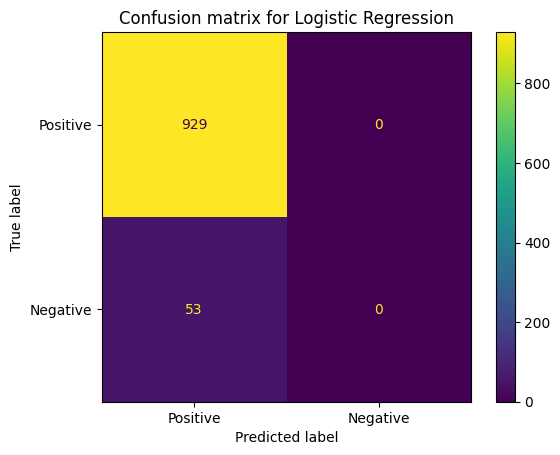

In [ ]:
confusion = confusion_matrix(y_test, lr_pred)
report = classification_report(y_test, lr_pred)
precision = precision_score(y_test, lr_pred)
recall = recall_score(y_test, lr_pred)
f1 = f1_score(y_test, lr_pred)
accuracy = accuracy_score(y_test, lr_pred)
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, lr_pred)}")
print(f"Recall: {recall_score(y_test, lr_pred)}")
print(f"F1 Score: {f1_score(y_test, lr_pred)}")
print(f"Accuracy: {accuracy_score(y_test, lr_pred)}\n")
plot_confusion_matrix(best_model_lr, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Confusion matrix for Logistic Regression')
plt.show()

## K-nearest neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 5,metric='minkowski',p=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(p=1)

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
}


In [ ]:
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

In [ ]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsClassifier(p=1),
             n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
best_model_knn = grid_search_knn.best_estimator_
print(f"Best estimator: {best_model_knn}")

Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)


In [ ]:
knn_accuracy = best_model_knn.score(X_test, y_test)
print(f"KNN accuracy: {knn_accuracy}")

KNN accuracy: 0.9460285132382892


In [ ]:
knn_pred=best_model_knn.predict(X_test)
knn_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Confusion Matrix: 
[[928   1]
 [ 52   1]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.50      0.02      0.04        53

    accuracy                           0.95       982
   macro avg       0.72      0.51      0.50       982
weighted avg       0.92      0.95      0.92       982

Precision: 0.5
Recall: 0.018867924528301886
F1 Score: 0.03636363636363636
Accuracy: 0.9460285132382892

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


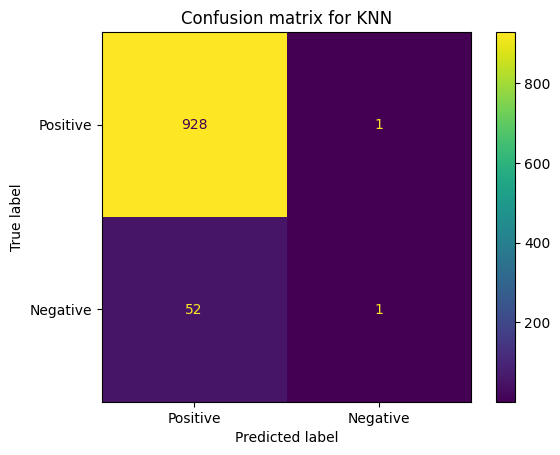

In [ ]:
confusion = confusion_matrix(y_test, knn_pred)
report = classification_report(y_test, knn_pred)
precision = precision_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)
f1 = f1_score(y_test, knn_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, knn_pred)}")
print(f"Recall: {recall_score(y_test, knn_pred)}")
print(f"F1 Score: {f1_score(y_test, knn_pred)}")
print(f"Accuracy: {accuracy_score(y_test, knn_pred)}\n")
plot_confusion_matrix(best_model_knn, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Confusion matrix for KNN')
plt.show()

## Decision trees

In [ ]:
DT = DecisionTreeClassifier(random_state= 42)
DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
grid_search_dt = GridSearchCV(DT, param_grid, cv=10)
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
best_model_dt = grid_search_dt.best_estimator_
DT_accuracy= best_model_dt.score(X_test, y_test)
print(f"Best estimator: {best_model_dt}")
print("Accuracy on test set:",DT_accuracy)

Best estimator: DecisionTreeClassifier(max_depth=1, max_features='sqrt', random_state=42)
Accuracy on test set: 0.9460285132382892


In [ ]:
DT_pred = best_model_dt.predict(X_test)
DT_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Confusion Matrix: 
[[929   0]
 [ 53   0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9460285132382892

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

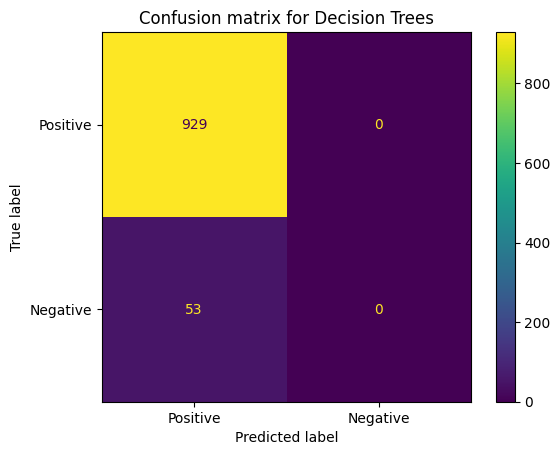

In [ ]:
confusion = confusion_matrix(y_test, DT_pred)
report = classification_report(y_test, DT_pred)
precision = precision_score(y_test, DT_pred)
recall = recall_score(y_test, DT_pred)
f1 = f1_score(y_test, DT_pred)
DT_accuracy = accuracy_score(y_test, DT_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, DT_pred)}")
print(f"Recall: {recall_score(y_test, DT_pred)}")
print(f"F1 Score: {f1_score(y_test, DT_pred)}")
print(f"Accuracy: {accuracy_score(y_test, DT_pred)}\n")
plot_confusion_matrix(best_model_dt, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Confusion matrix for Decision Trees')
plt.show()

## Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=0)
perceptron.fit(X_train, y_train)

Perceptron()

In [ ]:
param_grid_perceptron = {'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'alpha': [0.0001, 0.001, 0.01]}

In [ ]:
grid_search_perceptron = GridSearchCV(perceptron, param_grid_perceptron, cv=10, scoring='f1', error_score='raise')
grid_search_perceptron.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise', estimator=Perceptron(),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [ ]:
best_model_perceptron = grid_search_perceptron.best_estimator_
print(f"Best estimator: {best_model_perceptron}")
perceptron_accuracy = best_model_perceptron.score(X_test, y_test)
print(f"Perceptron accuracy: {perceptron_accuracy}")

Best estimator: Perceptron(max_iter=100, penalty='elasticnet')
Perceptron accuracy: 0.9389002036659878


In [ ]:
perceptron.fit(X_train, y_train)

Perceptron()

In [ ]:
p_pred = best_model_perceptron.predict(X_test)
p_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.32      0.11      0.17        53

    accuracy                           0.94       982
   macro avg       0.63      0.55      0.57       982
weighted avg       0.92      0.94      0.93       982

Precision: 0.3157894736842105
Recall: 0.11320754716981132
F1 Score: 0.16666666666666666
Accuracy: 0.9389002036659878

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


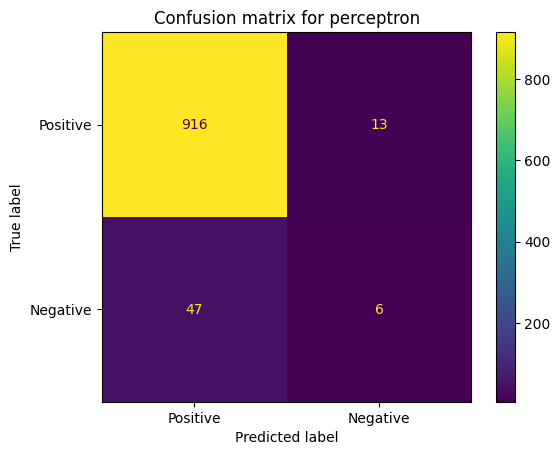

In [ ]:
confusion = confusion_matrix(y_test, p_pred)
report = classification_report(y_test, p_pred)
precision = precision_score(y_test, p_pred)
recall = recall_score(y_test, p_pred)
f1 = f1_score(y_test, p_pred)
accuracy = accuracy_score(y_test, p_pred)
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, p_pred)}")
print(f"Recall: {recall_score(y_test, p_pred)}")
print(f"F1 Score: {f1_score(y_test, p_pred)}")
print(f"Accuracy: {accuracy_score(y_test, p_pred)}\n")
plot_confusion_matrix(best_model_perceptron, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Confusion matrix for perceptron')
plt.show()

# Models evaluation

## Average accuracy of all models

In [ ]:
result = pd.DataFrame({
    'Algorithm' : ['LogisticRegression', 'K-nearest neighbors', 'DecisionTree', 'Perceptron'],
    'Score' : [lr_accuracy, knn_accuracy, DT_accuracy, perceptron_accuracy],
})

result

,Algorithm,Score
0,LogisticRegression,0.946029
1,K-nearest neighbors,0.946029
2,DecisionTree,0.946029
3,Perceptron,0.938900


In [ ]:
Average_accuracy = (lr_accuracy+knn_accuracy+DT_accuracy+perceptron_accuracy)/4
Average_accuracy*100

94.42464358452139

## Ensemble training

In [ ]:
from sklearn.ensemble import VotingClassifier
vc=VotingClassifier(estimators=[("Logistic Regression",lr),("KNN",knn),("Decision Tree",DT), ("Perceptron",  perceptron)])
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('Logistic Regression', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(p=1)),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('Perceptron', Perceptron())])

In [ ]:
vc_pred=vc.predict(X_test)
vc_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
Voting_accuracy=accuracy_score(y_test,vc_pred)
Voting_accuracy*100

94.60285132382892

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2df167fa-6f49-49f3-9bd7-d669fc762994' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>